## Сверточные нейронные сети (Convolutional networks, ConvNet, CNN)

понятное [видео](https://www.youtube.com/watch?v=bNb2fEVKeEo) со стенфордского курса, из [материалов](https://cs231n.github.io/convolutional-networks) по которому взяты иллюстрации.

Датасет из [курса](https://github.com/DanAnastasyev/DeepNLP-Course/blob/master/Week%2004/Week_04_Convolutional_Neural_Networks.ipynb) Даниила Анастасьева.

Использовались [материалы](https://github.com/mannefedov/hse_ml_m1/blob/master/7_cnn/cnn.ipynb) из курса Михаила Нефедова.

In [ ]:
from IPython.display import Image

## Сверточный слой




Желтое - фильтр (= filter,kernel).

Зеленое - входные данные, например, изображение.

Розовое - карта активации (activation map).

Каждый элемент в розовой матрице - результат поэлементного умножения фильтра на числа из области на входных данных.
Обучаемые параметры - элементы фильтра.

![Conv](https://image.ibb.co/e6t8ZK/Convolution.gif)



Чтобы не терять размер матрицы используется паддинг.

![padding](https://3deep.ru/wp-content/uploads/2020/01/keras_conv2d_padding.gif)

from https://3deep.ru/machinelearning/

## Pooling слой  (не обучается)

![Pool](https://cs231n.github.io/assets/cnn/pool.jpeg)
![maxpool](https://cs231n.github.io/assets/cnn/maxpool.jpeg)

### Свертки для текстов устроены немного по-другому. В них на одну размерность меньше.

![text-convs](https://image.ibb.co/bC3Xun/2018_03_27_01_24_39.png)

From [Character-Aware Neural Language Models](https://arxiv.org/pdf/1508.06615.pdf)

## CNN для обработки текстов
#### пример построения сети в keras 


In [16]:
import tensorflow as tf

In [1]:
import pandas as pd
import numpy as np
#from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
#%matplotlib inline

In [2]:
!wget -O surnames.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1z7avv1JiI30V4cmHJGFIfDEs9iE4SHs5"

In [5]:
len(data)

80523

In [4]:
with open('surnames.txt') as f:
    lines = f.readlines()
    data = [line.strip().split('\t')[0] for line in lines]
    labels = np.array([int(line.strip().split('\t')[1]) for line in lines])
    del lines
    
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.33, random_state=42, stratify=labels)

In [6]:
list(zip(test_data[:10], test_labels[:10]))

[('ЗАКОНОМЕРНОСТИ', 0),
 ('Нагель', 1),
 ('Оуэн', 1),
 ('Гну', 0),
 ('перемоткам', 0),
 ('погруженности', 0),
 ('квартиросъемщики', 0),
 ('лексикой', 0),
 ('Карсёкий', 1),
 ('подполковники', 0)]

In [7]:
# мы будем работать на уровне букв, создаем словарь на трейне
vocab = Counter()
for word in train_data:
    vocab.update(list(word))

In [8]:
# выкидываем редкие символы
filtered_vocab = set()
for char in vocab:
    if vocab[char] > 5:
        filtered_vocab.add(char)

In [9]:
filtered_vocab

{' ',
 '-',
 '.',
 'Ё',
 'А',
 'Б',
 'В',
 'Г',
 'Д',
 'Е',
 'Ж',
 'З',
 'И',
 'Й',
 'К',
 'Л',
 'М',
 'Н',
 'О',
 'П',
 'Р',
 'С',
 'Т',
 'У',
 'Ф',
 'Х',
 'Ц',
 'Ч',
 'Ш',
 'Щ',
 'Ъ',
 'Ы',
 'Ь',
 'Э',
 'Ю',
 'Я',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё'}

In [10]:
# индексируем буквы
char2id = {'UNK':1, 'PAD':0}

for char in filtered_vocab:
    char2id[char] = len(char2id)

In [11]:
id2char = {i:char for char, i in char2id.items()}

In [12]:
for i in range(20):
  print(i, id2char[i])

0 PAD
1 UNK
2 б
3 Э
4  
5 И
6 Ц
7 К
8 П
9 Д
10 с
11 ц
12 ф
13 у
14 М
15 С
16 Б
17 а
18 в
19 к


In [13]:
max_word_len = max(len(x) for x in train_data) #32


In [17]:
#конвертируем трейн и тест в матрицы, где каждое слово  - вектор индексов длины 32
def convert_data(data, char2id, max_word_len):
  X = []
  for word in data:
    chars = list(word)
    ids = [char2id.get(char, 1) for char in chars]
    X.append(ids)
  X = tf.keras.preprocessing.sequence.pad_sequences( X, maxlen=max_word_len, truncating='pre')
  return(X)


In [18]:
X_train = convert_data(train_data, char2id=char2id, max_word_len=max_word_len) #(53950, 32)

In [19]:
X_test = convert_data(test_data, char2id=char2id, max_word_len=max_word_len) #(26573, 32)

Нам нужна метрика  f1, а в keras ее по дефолту нет. Для быстроты нагуглено тут https://www.kaggle.com/c/liverpool-ion-switching/discussion/132646

In [20]:
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

Перед тем, как собрать сеть, посмотрим как создать слой

In [21]:
embeddings = tf.keras.layers.Embedding(input_dim=len(char2id), output_dim=8)

In [22]:
X_test[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, 45, 57,  7, 32, 52, 32, 14, 41, 43, 52, 32, 15, 54,  5],
      dtype=int32)

In [23]:
embeddings(X_test[0])

<tf.Tensor: shape=(32, 8), dtype=float32, numpy=
array([[-0.02309396, -0.01495552,  0.01650709, -0.02933526, -0.03833922,
         0.02998331, -0.00662179,  0.00381867],
       [-0.02309396, -0.01495552,  0.01650709, -0.02933526, -0.03833922,
         0.02998331, -0.00662179,  0.00381867],
       [-0.02309396, -0.01495552,  0.01650709, -0.02933526, -0.03833922,
         0.02998331, -0.00662179,  0.00381867],
       [-0.02309396, -0.01495552,  0.01650709, -0.02933526, -0.03833922,
         0.02998331, -0.00662179,  0.00381867],
       [-0.02309396, -0.01495552,  0.01650709, -0.02933526, -0.03833922,
         0.02998331, -0.00662179,  0.00381867],
       [-0.02309396, -0.01495552,  0.01650709, -0.02933526, -0.03833922,
         0.02998331, -0.00662179,  0.00381867],
       [-0.02309396, -0.01495552,  0.01650709, -0.02933526, -0.03833922,
         0.02998331, -0.00662179,  0.00381867],
       [-0.02309396, -0.01495552,  0.01650709, -0.02933526, -0.03833922,
         0.02998331, -0.0066217

In [ ]:
embeddings.weights

[<tf.Variable 'embedding_4/embeddings:0' shape=(71, 100) dtype=float32, numpy=
 array([[ 0.02376633,  0.04967678, -0.00634187, ..., -0.00034356,
          0.00228524, -0.00866852],
        [-0.00325005, -0.00808334, -0.00201429, ..., -0.00533789,
         -0.00310986, -0.00958718],
        [ 0.04685852,  0.03094024, -0.04027497, ..., -0.02365741,
         -0.01615051,  0.01306324],
        ...,
        [-0.00921313,  0.02374442, -0.03062375, ...,  0.01393238,
         -0.03453756,  0.03717487],
        [ 0.01466973,  0.04473562,  0.02118998, ..., -0.017128  ,
          0.02081032, -0.0049126 ],
        [-0.01026732, -0.02863084,  0.01287926, ...,  0.04817791,
          0.00510374, -0.01457874]], dtype=float32)>]

Посмотрим, как строится полносвязная сеть

In [24]:
inputs = tf.keras.layers.Input(shape=(max_word_len))
embeddings = tf.keras.layers.Embedding(input_dim=len(char2id), output_dim=8)(inputs)
flatten = tf.keras.layers.Flatten()(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])



In [ ]:
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 32, 15)            1065      
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                30784     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 31,914
Trainable params: 31,914
Non-trainable params: 0
_________________________________________________________________


In [25]:
model1.fit(X_train, train_labels, 
          validation_data=(X_test, test_labels),
          batch_size=200,
         epochs=20)

Epoch 1/20
270/270 [==============================] - 1s 4ms/step - loss: 0.3365 - f1: 0.0598 - val_loss: 0.2752 - val_f1: 0.3222
Epoch 2/20
270/270 [==============================] - 1s 3ms/step - loss: 0.2592 - f1: 0.3882 - val_loss: 0.2567 - val_f1: 0.3774
Epoch 3/20
270/270 [==============================] - 1s 3ms/step - loss: 0.2466 - f1: 0.4497 - val_loss: 0.2472 - val_f1: 0.4417
Epoch 4/20
270/270 [==============================] - 1s 3ms/step - loss: 0.2376 - f1: 0.4828 - val_loss: 0.2397 - val_f1: 0.4912
Epoch 5/20
270/270 [==============================] - 1s 3ms/step - loss: 0.2298 - f1: 0.5002 - val_loss: 0.2331 - val_f1: 0.5036
Epoch 6/20
270/270 [==============================] - 1s 3ms/step - loss: 0.2235 - f1: 0.5212 - val_loss: 0.2288 - val_f1: 0.4822
Epoch 7/20
270/270 [==============================] - 1s 3ms/step - loss: 0.2190 - f1: 0.5349 - val_loss: 0.2249 - val_f1: 0.5244
Epoch 8/20
270/270 [==============================] - 1s 3ms/step - loss: 0.2141 - f1: 0.5

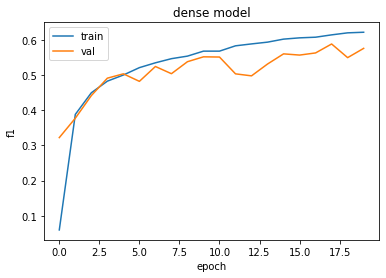

In [26]:
plt.plot(model1.history.history['f1'])
plt.plot(model1.history.history['val_f1'])
plt.title('dense model')
plt.xlabel('epoch')
plt.ylabel('f1')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Чтобы добавлять сверточные слои, будем использовать Conv1D.
Его параметры:

**kernel_size** - ширина фильтра (окна, которым мы идем по последовательности)

**filters** - количество фильтров (каждый фильтр формирует на выходе свою карту активации, соответсвенно сколько фильтров - такая и величина третьей размерности в выходной матрице)

**strides** - шаг, с которым применяется фильтр

**paddings** - надо ли добавлять паддинги перед проходом фильтров, чтобы размер матрицы не уменьшался



In [30]:
inputs = tf.keras.layers.Input(shape=(max_word_len))
embeddings = tf.keras.layers.Embedding(input_dim=len(char2id), output_dim=8)(inputs)

conv1 = tf.keras.layers.Conv1D(kernel_size=2, filters=16,  padding='same')(embeddings)

conv2 = tf.keras.layers.Conv1D(kernel_size=3, filters=64, padding='same')(embeddings)
conv2 = tf.keras.layers.Dropout(0.2)(conv2)


concat = tf.keras.layers.Concatenate(axis=2)([conv1,conv2])
concat = tf.keras.layers.MaxPooling1D()(concat)
flatten = tf.keras.layers.Flatten()(concat)

dense = tf.keras.layers.Dense(64, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])
#AveragePooling1D()  Dropout(0.2)


In [31]:
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 32, 8)        568         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 32, 64)       1600        embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 32, 16)       272         embedding_4[0][0]                
_______________________________________________________________________________________

In [32]:
model2.fit(X_train,train_labels,
          validation_data=(X_test, test_labels),
          batch_size=200,
         epochs=20)

Epoch 1/20
270/270 [==============================] - 6s 22ms/step - loss: 0.3277 - f1: 0.0012 - val_loss: 0.2739 - val_f1: 0.1393
Epoch 2/20
270/270 [==============================] - 6s 21ms/step - loss: 0.2576 - f1: 0.3786 - val_loss: 0.2523 - val_f1: 0.4990
Epoch 3/20
270/270 [==============================] - 6s 21ms/step - loss: 0.2389 - f1: 0.4833 - val_loss: 0.2402 - val_f1: 0.5405
Epoch 4/20
270/270 [==============================] - 6s 21ms/step - loss: 0.2267 - f1: 0.5237 - val_loss: 0.2265 - val_f1: 0.5222
Epoch 5/20
270/270 [==============================] - 6s 21ms/step - loss: 0.2164 - f1: 0.5506 - val_loss: 0.2188 - val_f1: 0.5529
Epoch 6/20
270/270 [==============================] - 6s 22ms/step - loss: 0.2086 - f1: 0.5748 - val_loss: 0.2133 - val_f1: 0.5467
Epoch 7/20
270/270 [==============================] - 6s 22ms/step - loss: 0.2026 - f1: 0.5864 - val_loss: 0.2092 - val_f1: 0.5538
Epoch 8/20
270/270 [==============================] - 6s 22ms/step - loss: 0.1985 -

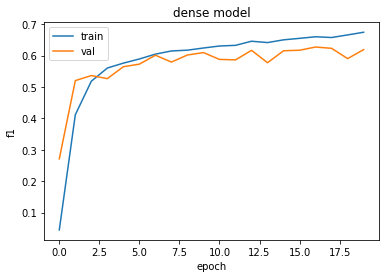

In [ ]:
plt.plot(model2.history.history['f1'])
plt.plot(model2.history.history['val_f1'])
plt.title('dense model')
plt.xlabel('epoch')
plt.ylabel('f1')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Сохранение и загрузка модели

## Callbacks

In [ ]:
# лучшие результаты сохраняем
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_f1',
                                                verbose=1,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='max'
                                               )

# если нет улучшений, останавливаем обучение
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, # на сколько нужно улучшиться метрике, чтобы мы посчитали, что что-то улучшилось
                                              patience=3, # сколько ждать улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [ ]:
inputs = tf.keras.layers.Input(shape=(max_word_len))
embeddings = tf.keras.layers.Embedding(input_dim=len(char2id), output_dim=10)(inputs)

conv1 = tf.keras.layers.Conv1D(kernel_size=2, filters=16, padding='same')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, padding='same')(conv1)
dropout = tf.keras.layers.Dropout(0.2)(conv2)

flatten = tf.keras.layers.Flatten()(dropout)

dense = tf.keras.layers.Dense(64, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [ ]:

model3.fit(X_train,train_labels,
          validation_data=(X_test, test_labels),
          batch_size=200,
         epochs=20,
         callbacks=[checkpoint, early_stopping])

Epoch 1/20
268/270 [============================>.] - ETA: 0s - loss: 0.3037 - f1: 0.1412
Epoch 00001: val_f1 improved from -inf to 0.41854, saving model to model.weights
270/270 [==============================] - 4s 16ms/step - loss: 0.3035 - f1: 0.1443 - val_loss: 0.2595 - val_f1: 0.4185
Epoch 2/20
269/270 [============================>.] - ETA: 0s - loss: 0.2497 - f1: 0.4577
Epoch 00002: val_f1 improved from 0.41854 to 0.45817, saving model to model.weights
270/270 [==============================] - 4s 15ms/step - loss: 0.2498 - f1: 0.4574 - val_loss: 0.2434 - val_f1: 0.4582
Epoch 3/20
268/270 [============================>.] - ETA: 0s - loss: 0.2315 - f1: 0.4969
Epoch 00003: val_f1 improved from 0.45817 to 0.51785, saving model to model.weights
270/270 [==============================] - 4s 15ms/step - loss: 0.2313 - f1: 0.4978 - val_loss: 0.2303 - val_f1: 0.5178
Epoch 4/20
267/270 [============================>.] - ETA: 0s - loss: 0.2230 - f1: 0.5177
Epoch 00004: val_f1 did not imp

Сохранение модели целиком:

In [ ]:
model.save('model')
model = tf.keras.models.load_model('model')

INFO:tensorflow:Assets written to: model/assets


Сохранить отдельно веса:

In [ ]:
model.save_weights('model.weights')
model.load_weights('model.weights')